### OLAP Queries

#### Funções utilitárias

In [5]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt

HOST = "10.101.151.25"
DATABASE = "tpd017"
USER = "tpd017"
PASSWORD = "tpd017" 

# Execute a single statement.
def execute_single_sql_statement(sql):
    conn = pg.connect(host=HOST,database=DATABASE, user=USER, password=PASSWORD)    
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()
    conn.close()    

# Return output of query in dataframe
def getSQLfromQuery(sql, params):
    conn = pg.connect(host=HOST,database=DATABASE, user=USER, password=PASSWORD)
    cur  = conn.cursor()    
    if len(params)==0:
        cur.execute(sql)
    else: 
        cur.execute(sql, params)
    data = cur.fetchall()
    colnames = [desc[0] for desc in cur.description]
    cur.close()
    conn.close()
    df=pandafy(data, colnames)
    return df

# Create a dataframe
def pandafy(rows, colnames):
    N=len(colnames)
    D={cn: [] for cn in colnames}
    for row in rows:
        for i in range(N): D[colnames[i]].append(row[i])
    pdfy=pd.DataFrame(D)
    return pdfy


3. **Assumindo que os diferentes níveis de urbanismo nos municípios afetam a quantidade de tráfego nos mesmos, esse aumento também vai ocorrer no número de acidentes e na severidade dos mesmos?** 


* **Objetivo da interrogação**: Análise e visualização, para cada nível de urbanismo, do número de acidentes, e da distribuição da severidade nos mesmos, de modo a entender padrões à medida que o urbanismo aumenta.
* **Dimensões relevantes**: 
    * Facts Table: ligação à dimensão Location (atributo `LocationKey`)
    * Location: para recolha dos diferentes níveis de urbanismo (atributo `UrbanRuralClassification`)
    * Severity: para recolha das diferentes severidades dos acidentes (atributo-chave `SeverityKey`)
* **Relevância para quais processos?**
    * Seguradoras: adequação de valores através da prevalência de determinados acidentes em certas zonas
    * Policiamento: dado o número de acidentes, adaptação de meios de vigiliância e cooperação
    * Estruturas de controlo de tráfego: recolha de informação para identificação de zonas mais vulneráveis

**Interrogação**:

``
SELECT ft.severitykey, l.urban_rural_classification, COUNT(*) AS number_of_accidents
from facts_table ft, location_dimension l
WHERE ft.locationkey = l.location_key
GROUP BY l.urban_rural_classification, ft.severitykey
ORDER BY l.urban_rural_classification, ft.severitykey
``


In [35]:
SQL="""
SELECT ft.severitykey, l.urban_rural_classification, COUNT(*) AS number_of_accidents
from facts_table ft, location_dimension l
WHERE ft.locationkey = l.location_key
GROUP BY l.urban_rural_classification, ft.severitykey
ORDER BY l.urban_rural_classification, ft.severitykey
"""

df = getSQLfromQuery(SQL, ())

In [36]:
df['urban_rural_classification'] = df['urban_rural_classification'].apply(lambda x: x.rstrip())
df

,severitykey,urban_rural_classification,number_of_accidents
0,1,Large Central Metro,5
1,2,Large Central Metro,12664
2,3,Large Central Metro,5840
3,4,Large Central Metro,233
4,1,Large Fringe Metro,4
5,2,Large Fringe Metro,4504
6,3,Large Fringe Metro,2374
7,4,Large Fringe Metro,297
8,1,Medium Metro,4
9,2,Medium Metro,5234


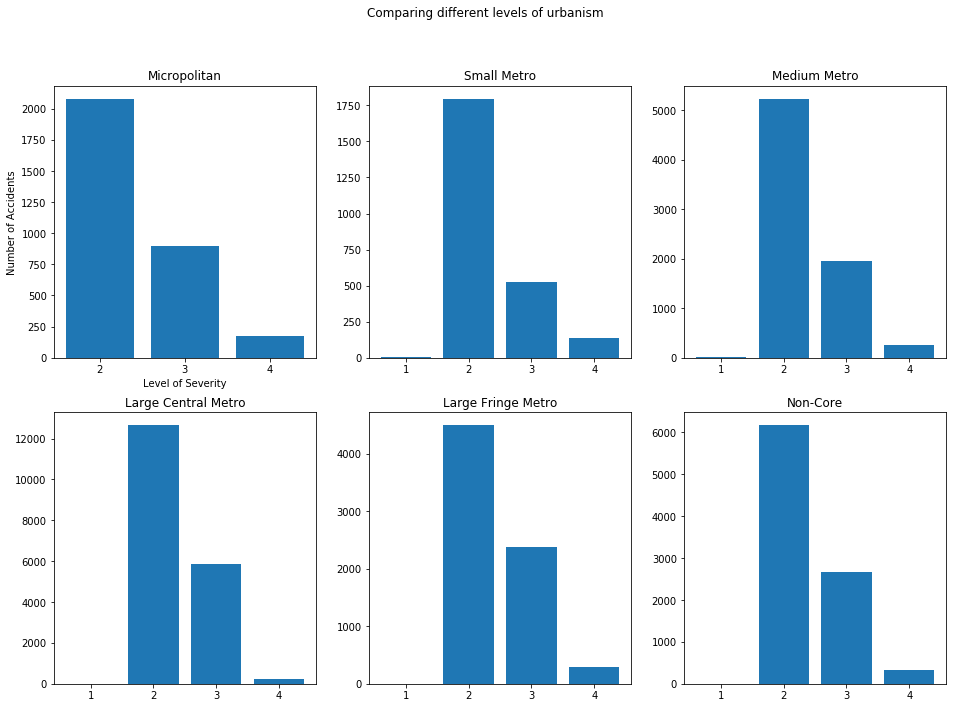

In [39]:
classes = list(set(df['urban_rural_classification'].values))
fig, axs = plt.subplots(2,3, figsize=(16,11))
fig.suptitle('Comparing different levels of urbanism')

for i, ax in enumerate(fig.axes):
    test = df.loc[df['urban_rural_classification'] == classes[i]].drop(columns=['urban_rural_classification'])
    ax.set_xticks(test['severitykey'].values)
    ax.bar(test['severitykey'].values, test['number_of_accidents'].values)
    ax.set_title(classes[i])
    if i == 0: 
        ax.set_xlabel("Level of Severity")
        ax.set_ylabel("Number of Accidents")
plt.show()